<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-09-tree-based-models-bagging-grf-multitask-regression-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.9 Multi-task Regression Forest

A **multi-task regression forest**, as implemented in the `{grf}` package in R, is an extension of the generalized random forest framework designed to handle multiple related regression tasks simultaneously. It leverages the structure of random forests to model multiple continuous outcomes (tasks) while accounting for potential correlations or shared patterns among them. This is particularly useful when the outcomes are related, and modeling them jointly can improve prediction accuracy or efficiency compared to fitting separate models for each task.


## Overview

A multi-task regression forest is a machine learning model that extends the random forest framework to predict multiple continuous outcomes (tasks) simultaneously. Instead of fitting a separate regression forest for each outcome, it builds a single forest that shares information across tasks, leveraging their relationships to improve predictions. In `{grf}`, this is implemented via the `multi_regression_forest()` function, which is designed to handle multiple response variables efficiently.



### Key features

- `Shared Tree Structure`: The forest uses a single set of decision trees, where splits are determined by optimizing a joint criterion across all tasks (e.g., minimizing the combined mean squared error).
- `Outcome-Specific Predictions`: Each tree provides predictions for all tasks, but the leaf estimates are tailored to each outcome.
- `Honest Splitting`: Like other `{grf}` models, it supports honest splitting to reduce bias, splitting data into separate subsets for tree structure and leaf estimation.
- `Flexibility`: It can handle high-dimensional data and is robust to non-linear relationships, similar to standard regression forests.


### How Multi-task Regression Forest Works in `{grf}`

The `multi_regression_forest()` function in `{grf}` works as follows:

1. Input Data

   - A feature matrix $X$ (predictors).
   - A matrix $Y$ with multiple columns, where each column represents a different continuous outcome (task).
   - Parameters like `num.trees`, `honesty`, and `min.node.size` to control the forest.

2. Tree Construction

   - Each tree is grown using a random subset of the data (via bootstrapping) and a random subset of features at each split.
   - Splits are chosen to minimize a combined loss function across all tasks, typically the sum of squared errors for all outcomes.
   - If `honesty = TRUE`, the data is split into two parts: one for determining the tree structure and another for estimating leaf values for each task.

3. Prediction

   - For a new data point, each tree assigns it to a leaf, and the predictions for each task are computed based on the average outcome values for that task in the leaf.
   - The final prediction for each task is the average across all trees.

4.  Output

   - A matrix of predictions, with one column per task.
   - Optional outputs like variable importance or variance estimates.



### Advantages of Multi-Task Regression Forests

1. `Improved Efficiency`: By sharing a single forest across tasks, it reduces computational overhead compared to fitting separate forests for each outcome.
2. `Leveraging Correlations`: If outcomes are related (e.g., housing price and tax rate), the model can exploit shared patterns to improve predictions.
3. `Robustness`: Like other `{grf}` models, it handles non-linear relationships, high-dimensional data, and noisy inputs effectively.
4. `Honest Estimation`: Supports honest splitting, reducing bias in predictions, especially for small datasets or complex tasks.
5. `Flexibility`: Can be used in settings where multiple outcomes need to be predicted, such as economics, healthcare, or social sciences.


### Limitations

1. `Assumes Related Tasks`: The model assumes that tasks share some underlying structure. If outcomes are unrelated, a multi-task forest may not outperform separate single-task forests.
2. `Increased Complexity`: Optimizing splits for multiple outcomes can be computationally more intensive per tree compared to a single-task forest.
3. `Interpretability`: While variable importance is available, interpreting the joint effect of features across multiple tasks can be challenging.
4. `Tuning*` Requires careful tuning of parameters (e.g., `num.trees`, `min.node.size`) to balance performance across all tasks.

#### `Key Differences from Standard Regression Forest`

| **Aspect**                     | **Standard Regression Forest** (`regression_forest`) | **Multi-Task Regression Forest** (`multi_regression_forest`) |
|--------------------------------|----------------------------------------------------|------------------------------------------------------------|
| `Number of Outcomes`         | Predicts a single continuous outcome.              | Predicts multiple continuous outcomes simultaneously.      |
| `Input for Y`                | A vector of one outcome (`Y`).                     | A matrix of multiple outcomes (`Y` with multiple columns).  |
| `Tree Splitting`             | Optimizes splits for a single outcome’s MSE.       | Optimizes splits for a combined loss across all outcomes.  |
| `Information Sharing`        | No sharing across outcomes (one model per outcome). | Shares tree structure across tasks, leveraging correlations. |
| `Use Case`                   | Single regression task (e.g., predict `medv`).     | Multiple related regression tasks (e.g., predict `medv` and `tax`). |
| `Computational Efficiency`   | Requires separate forests for multiple outcomes.   | More efficient by building one forest for all tasks.       |



## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314973 sha256=2dce982b604acc25b58e9cad7916a1c96bde97fa1b6d08b7fa2ddf4ebc75e6b0
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Multi-task Regression Forest with R

To illustrate, let’s use the Boston Housing dataset to predict two related outcomes: `medv` (median housing price) and `tax` (property tax rate). We’ll fit a `multi_regression_forest()`, predict on a test set, and evaluate performance.




### Load and Check Required Libraries

In [3]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'rdd',
              'survival',
              'mlbench',
              'Metrics'
         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf       rdd  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:rdd"       "package:Formula"   "package:AER"      
 [4] "package:car"       "package:carData"   "package:lmtest"   
 [7] "package:zoo"       "package:sandwich"  "package:Metrics"  
[10] "package:mlbench"   "package:survival"  "package:grf"      
[13] "package:plyr"      "package:lubridate" "package:forcats"  
[16] "package:stringr"   "package:dplyr"     "package:purrr"    
[19] "package:readr"     "package:tidyr"     "package:tibble"   
[22] "package:ggplot2"   "package:tidyverse" "package:tools"    
[25] "package:stats"     "package:graphics"  "package:grDevices"
[28] "package:utils"     "package:datasets"  "package:methods"  
[31] "package:base"     


### Load and Prepare the Dataset

The lung dataset contains survival data for lung cancer patients with variables like `time` (survival time), `status` (censoring indicator), `age`, s`ex`, and `ph.ecog` (ECOG performance score). We’ll simulate a binary `health_status `variable (1 = improved, 0 = not improved) and use age, sex, and ph.ecog as covariates.


In [5]:
%%R
# Load Boston Housing dataset
data(BostonHousing, package = "mlbench")
# Split data into training (70%) and test (30%) sets
# Set seed for reproducibility
set.seed(123)
n <- nrow(BostonHousing)
train_idx <- sample(1:n, size = 0.7 * n)
train_data <- BostonHousing[train_idx, ]
test_data <- BostonHousing[-train_idx, ]


### Prepare Features and Target Variable

In [9]:
%%R
# Prepare features (X) and multiple outcomes (Y)
X_train <- model.matrix(~ . - medv - tax, data = train_data)[, -1]  # Exclude medv, tax, intercept
Y_train <- as.matrix(train_data[, c("medv", "tax")])               # Matrix of outcomes
X_test <- model.matrix(~ . - medv - tax, data = test_data)[, -1]   # Exclude medv, tax, intercept
Y_test <- as.matrix(test_data[, c("medv", "tax")])

### Fit Multi-task Regression Forest

Fit a multi-task regression forest using the `multi_regression_forest()` function from the `{grf}` package. This function allows us to model multiple continuous outcomes simultaneously.

In [10]:
%%R
# Fit multi-task regression forest
multi_rf <- multi_regression_forest(X_train,
                                    Y_train,
                                    num.trees = 500,
                                    honesty = TRUE)
print(multi_rf)  # Print model summary

GRF forest object of type multi_regression_forest 
Number of trees: 500 
Number of training samples: 354 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10    11    12 
0.280 0.002 0.095 0.002 0.049 0.008 0.014 0.060 0.387 0.016 0.011 0.076 


### Predict on Test Set and Evaluate Model

In [11]:
%%R
# Predict on test set
predictions <- predict(multi_rf, X_test)$predictions

# Calculate RMSE for each task
rmse_medv <- sqrt(mean((predictions[, 1] - Y_test[, 1])^2))
rmse_tax <- sqrt(mean((predictions[, 2] - Y_test[, 2])^2))

# Calculate R-squared for each task
sst_medv <- sum((Y_test[, 1] - mean(Y_test[, 1]))^2)
sse_medv <- sum((predictions[, 1] - Y_test[, 1])^2)
r_squared_medv <- 1 - sse_medv / sst_medv

sst_tax <- sum((Y_test[, 2] - mean(Y_test[, 2]))^2)
sse_tax <- sum((predictions[, 2] - Y_test[, 2])^2)
r_squared_tax <- 1 - sse_tax / sst_tax

# Print performance metrics
cat("medv - RMSE:", rmse_medv, " R-squared:", r_squared_medv, "\n")
cat("tax - RMSE:", rmse_tax, " R-squared:", r_squared_tax, "\n")

medv - RMSE: 6.037645  R-squared: 0.588648 
tax - RMSE: 50.54847  R-squared: 0.9100317 


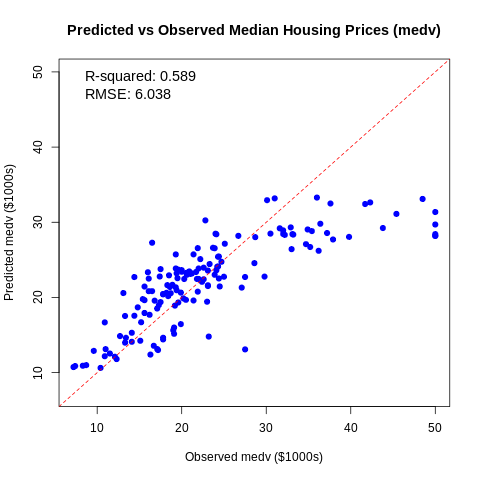

In [13]:
%%R
# Scatter plot for medv (first task)
plot(Y_test[, 1], predictions[, 1],
     main = "Predicted vs Observed Median Housing Prices (medv)",
     xlab = "Observed medv ($1000s)", ylab = "Predicted medv ($1000s)",
     pch = 19, col = "blue",
     xlim = range(c(Y_test[, 1], predictions[, 1])),
     ylim = range(c(Y_test[, 1], predictions[, 1])))
abline(0, 1, col = "red", lty = 2)
legend("topleft",
       legend = c(sprintf("R-squared: %.3f", r_squared_medv),
                  sprintf("RMSE: %.3f", rmse_medv)),
       bty = "n", cex = 1.2)

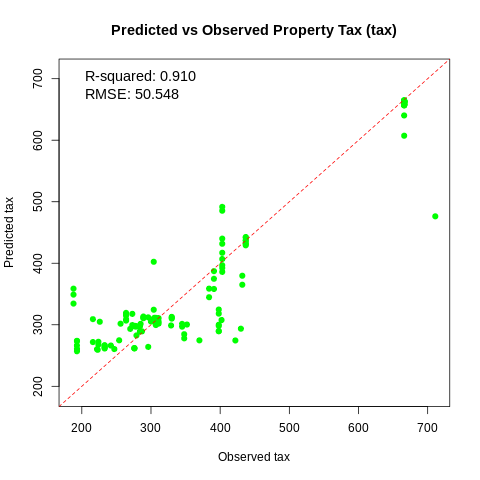

In [14]:
%%R
# Scatter plot for tax (second task)
plot(Y_test[, 2], predictions[, 2],
     main = "Predicted vs Observed Property Tax (tax)",
     xlab = "Observed tax", ylab = "Predicted tax",
     pch = 19, col = "green",
     xlim = range(c(Y_test[, 2], predictions[, 2])),
     ylim = range(c(Y_test[, 2], predictions[, 2])))
abline(0, 1, col = "red", lty = 2)
legend("topleft",
       legend = c(sprintf("R-squared: %.3f", r_squared_tax),
                  sprintf("RMSE: %.3f", rmse_tax)),
       bty = "n", cex = 1.2)

## Summary and Conclusion

Multi-task regression forests in `{grf}` provide a powerful framework for modeling multiple related continuous outcomes simultaneously. By leveraging shared information across tasks, they can improve prediction accuracy and computational efficiency compared to fitting separate models for each outcome. This tutorial demonstrated how to implement a multi-task regression forest using the Boston Housing dataset, predicting both median housing prices and property tax rates. The model's performance was evaluated using RMSE and R-squared metrics, showcasing its effectiveness in handling multiple regression tasks.
  


## References

1. Athey et al. (2019) on generalized random forests, and Wager & Athey (2018) on causal forests.

2. [Multi-task Regression Forest](https://grf-labs.github.io/grf/reference/multi_regression_forest.html)